In [1]:
from besos import eppy_funcs as ef

from besos.parameters import RangeParameter, expand_plist, wwr
from besos.objectives import clear_outputs
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem
from besos import optimizer
import platypus
from besos import sampling
import pandas as pd

import colorsys
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
building = ef.get_building()
clear_outputs(building)

parameters = expand_plist(
    #{'Name of object in idf':
    # {'Property Name':(min, max)}}
    {'NonRes Fixed Assembly Window':
     {'U-Factor':(0.1,5),
      'Solar Heat Gain Coefficient':(0.01,0.99)
     },
     'Mass NonRes Wall Insulation':{'Thickness':(0.01,0.09)},
    })
parameters.append(wwr())

objectives = ['Cooling:EnergyTransfer', 'Heating:EnergyTransfer', 'Electricity:Facility']

constraints = ['CO2:Facility']

problem = EPProblem(parameters, objectives, constraints, constraint_bounds=['<= 900'])

evaluator = EvaluatorEP(problem, building)

plat_problem = evaluator.to_platypus()

In [3]:
'FENESTRATIONSURFACE:DETAILED'.title()

'Fenestrationsurface:Detailed'

In [4]:
class LoggingArchive(platypus.Archive):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, *kwargs)
        self.log = []
    
    def add(self, solution):
        super().add(solution)
        self.log.append(solution)

In [5]:
archive = LoggingArchive()
solutions = optimizer.NSGAII(evaluator, population_size=10, archive=archive, evaluations=20)
df = optimizer.solutions_to_df(archive.log, problem=problem)

In [6]:
df

U-Factor  Solar Heat Gain Coefficient  Thickness  Window to Wall Ratio  \
0   1.860857                     0.081709   0.043064              0.677453   
1   2.078552                     0.862417   0.053255              0.688292   
2   0.829152                     0.588502   0.021941              0.306776   
3   4.676557                     0.184312   0.068369              0.205026   
4   0.415089                     0.729131   0.065847              0.104258   
5   1.786761                     0.134165   0.011244              0.462350   
6   3.744471                     0.609371   0.070323              0.152328   
7   2.404704                     0.028493   0.066209              0.731443   
8   0.555647                     0.083486   0.033545              0.274277   
9   2.182470                     0.395390   0.011956              0.627759   
10  0.445342                     0.165578   0.070814              0.197547   
11  4.908996                     0.079135   0.056760              0.265215   
12  0.881060                     0.697793   0.064119              0.317145   
13  2.461881                     0.862417   0.056867              0.688292   
14  1.804369                     0.088556   0.048546              0.677453   

    Cooling:EnergyTransfer  Heating:EnergyTransfer  Electricity:Facility  \
0             8.038416e+08            1.391649e+09          1.786308e+09   
1             8.581232e+08            1.321238e+09          1.822124e+09   
2             8.844241e+08            1.636672e+09          1.828785e+09   
3             7.887597e+08            1.294546e+09          1.780013e+09   
4             8.349880e+08            1.208148e+09          1.810954e+09   
5             8.903428e+08            1.904866e+09          1.821330e+09   
6             8.199343e+08            1.268427e+09          1.800112e+09   
7             7.760750e+08            1.259704e+09          1.772655e+09   
8             8.211623e+08            1.449633e+09          1.794869e+09   
9             9.045973e+08            1.894287e+09          1.831368e+09   
10            7.867882e+08            1.187746e+09          1.781629e+09   
11            7.865435e+08            1.357712e+09          1.776821e+09   
12            8.325381e+08            1.230176e+09          1.808864e+09   
13            8.545931e+08            1.308306e+09          1.820364e+09   
14            7.977366e+08            1.347872e+09          1.783850e+09   

    CO2:Facility  violation  pareto-optimal  
0     731.299275          0           False  
1     738.406091          0           False  
2     760.932355          0           False  
3     722.779969          0           False  
4     727.209090          0           False  
5     776.167656          0           False  
6     727.657408          0           False  
7     718.045133          0            True  
8     737.956654          0           False  
9     778.760509          0           False  
10    716.210371          0            True  
11    725.915022          0           False  
12    727.986664          0           False  
13    736.962591          0           False  
14    727.572648          0           False

Text(0, 0.5, 'Heating:EnergyTransfer')

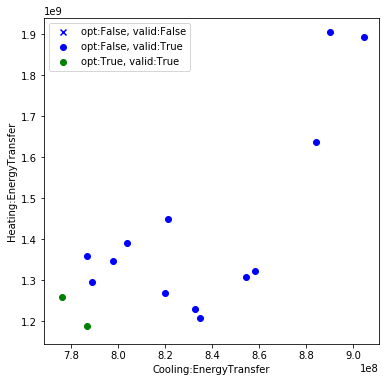

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

a = df['pareto-optimal']
b = df['violation'] == 0

x_label = 'Cooling:EnergyTransfer'
y_label = 'Heating:EnergyTransfer'

for optimal, valid in ((False, False), (False, True), (True, True)):
    if optimal:
        colour = 'g'
    else:
        colour = 'b'
    if valid:
        marker = 'o'
    else:
        marker = 'x'
    mask = (a==optimal) & (b==valid)
    d = df[mask]
    ax.scatter(x=d[x_label], y=d[y_label], marker=marker,
               c=colour, label=f'opt:{optimal}, valid:{valid}')

ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
# ax.set_ylim(0,2*10**9)
# ax.set_xlim(0,2*10**9)

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


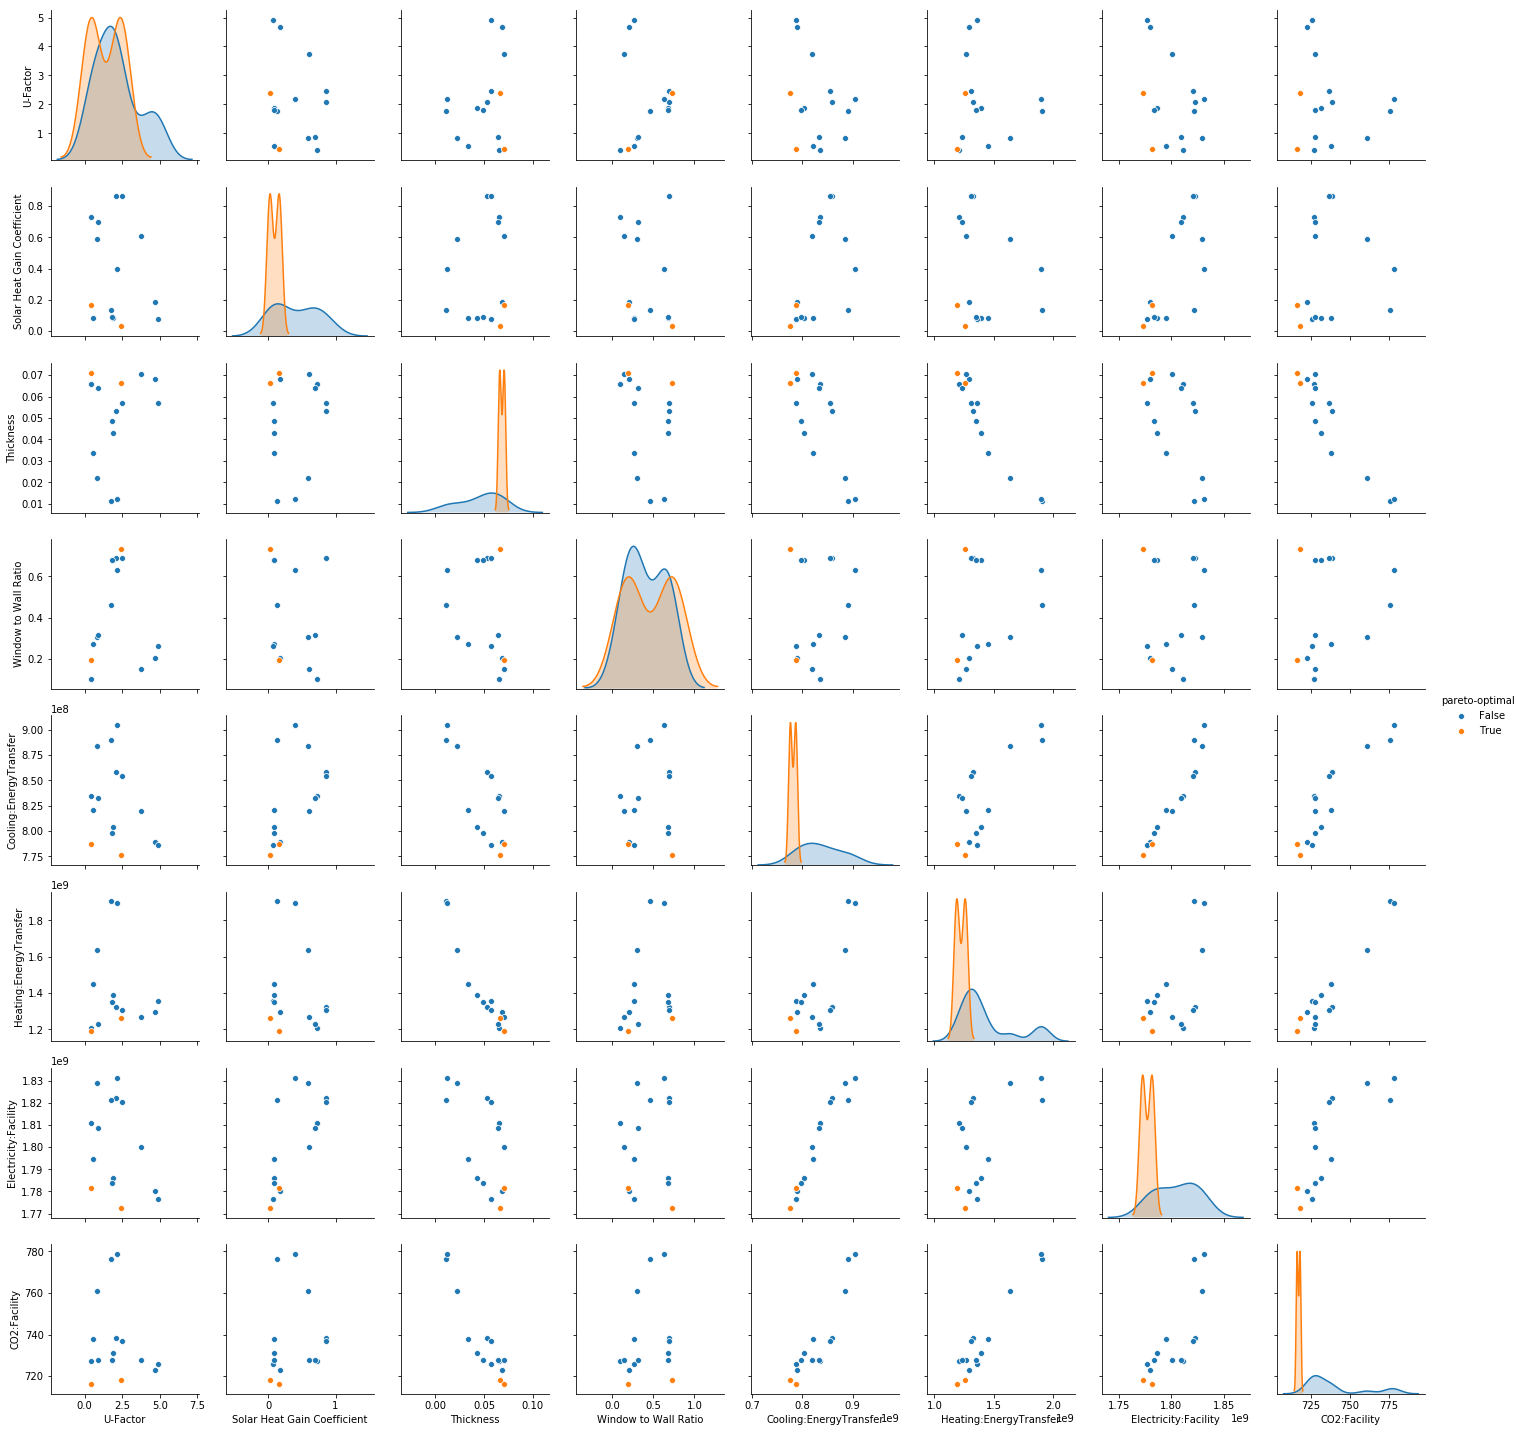

In [8]:
sns.pairplot(df, vars=problem.names(('inputs', 'outputs', 'constraints')), hue='pareto-optimal')

In [9]:
# adapted from https://stackoverflow.com/q/34071476/8061009
def heatmap(df, problem, parts=('inputs', 'outputs'), sort_by=None, cspace=2, figsize=(6,6)):
    if isinstance(parts, str):
        parts = (parts,)
    columns = problem.names(parts)
    if sort_by:
        df = df.sort_values(sort_by)
    df = df[columns]
    part_map = {part: {'names':problem.names(part)} for part in parts}
    num_colours = sum(len(v['names']) for v in part_map.values()) + cspace * (len(part_map)-1)
    for v in part_map.values():
        v['colours'] = [colorsys.hsv_to_rgb(x*1.0/(num_colours), 0.7, 0.5) for x in range(len(v['names']))]
    
    fig, ax = plt.subplots(figsize=figsize)

    with sns.axes_style('white'):
        for v in part_map.values():
            for colors, name in zip(v['colours'], v['names']):
                # Create cmap
                cmap = sns.light_palette(colors, input='rgb', reverse=False, as_cmap=True)

                sns.heatmap(df.mask(df.isin(df[name])!=1),
                            ax=ax,
                            cbar=False,
                            square=True,
                            annot=False,
                            cmap=cmap,
                            linewidths=0.1)
    ax.yaxis.set_visible(False)
    plt.show()

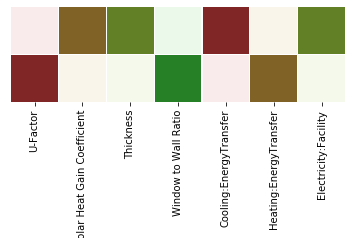

In [10]:
heatmap(df[df['pareto-optimal']], problem, sort_by='Heating:EnergyTransfer')

In [11]:
def par_coodrs(df, selector=None, label='selected', filter_=None, default_label='no_label',
              figsize=(10,8), columns=None, limit=None):
    fig, ax = plt.subplots(figsize=figsize) 
    for column in df:
        if df[column].min() == df[column].max():
            if columns is not None and column in columns:
                columns.remove(column)
                print(column, 'has a constant value of', df[column].min())
            df = df.drop(column, axis=1)
            
    
    df = (df - df.min())/(df.max()-df.min())
    
    df['colour'] = default_label
    if selector is not None:
        df.loc[selector, 'colour'] = label
    if filter_ is not None:
        df = df[filter_]
    if columns:
        df = df[columns + ['colour']]
    if limit is not None:
        df = df.sample(limit)
    parallel_coordinates(df, 'colour', colormap='prism', ax=ax)
    ax.yaxis.set_visible(False)
    plt.show()

In [12]:
columns = problem.names(('inputs', 'outputs', 'constraints'))
columns

['U-Factor',
 'Solar Heat Gain Coefficient',
 'Thickness',
 'Window to Wall Ratio',
 'Cooling:EnergyTransfer',
 'Heating:EnergyTransfer',
 'Electricity:Facility',
 'CO2:Facility']

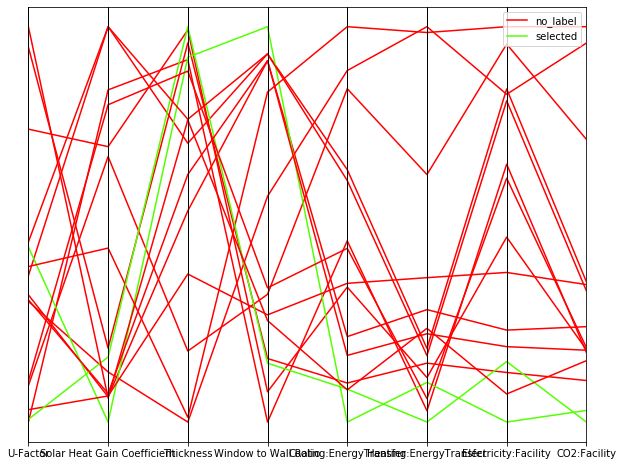

In [13]:
par_coodrs(df,
           selector=(df['violation'] == 0) & (df['pareto-optimal']),
           columns=problem.names(('inputs', 'outputs', 'constraints')))